### NLP CARES - Model


---

**Librarys**

In [6]:
%load_ext watermark
%watermark --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
matplotlib       3.1.1
logging          0.5.1.2
matplotlib.pylab 1.17.2
re               2.2.1
numpy            1.17.2
numba            0.45.1
pandas           0.25.1
sklearn          0.22.1
spacy            2.2.3
yellowbrick      1.0.1



In [5]:
import pandas as pd
import re
import numpy as np
from numba import jit
import pickle

#NLP
from spacy.lang.es.stop_words import STOP_WORDS
import spacy
#The vocabulary in spanish
nlp = spacy.load('es_core_news_sm')
#Stop_Words
nlp.vocab["no"].is_stop = False
nlp.vocab["realizado"].is_stop = False
nlp.vocab["sin"].is_stop = False
nlp.vocab["tener"].is_stop = False
nlp.vocab["manifestó"].is_stop = False
nlp.vocab["existe"].is_stop = False
nlp.vocab["considera"].is_stop = False
nlp.vocab["estados"].is_stop = False

#Algoritms / Graphics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from yellowbrick.classifier import ClassificationReport, DiscriminationThreshold, ROCAUC, ConfusionMatrix
from sklearn.svm import SVC

%pylab inline

Populating the interactive namespace from numpy and matplotlib


---
**Import Dataset**

In [2]:
df_train = pd.read_hdf('../../data/data.h5', 'TRAIN')
df_test = pd.read_hdf('../../data/test.h5', 'TEST')

In [3]:
print(df_train.shape,
     df_test.shape)

(26969, 10) (2881, 10)


In [4]:
# remove empty comments

df_train = df_train.drop([i for i in df_train.index if not df_train.loc[i, 'tokenized_sentences']])
df_test = df_test.drop([i for i in df_test.index if not df_test.loc[i, 'tokenized_sentences']])

In [5]:
# load W2V model

W2Vmodel = pickle.load( open("../Final_Models/W2Vmodel.pickle", "rb"))

In [6]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

In [7]:
%%time
w2v_features = list(map(lambda sen_group: get_w2v_features(W2Vmodel, sen_group), df_train['tokenized_sentences']))
X_w2v = np.array(list(map(np.array, w2v_features)))
Z=pd.DataFrame(X_w2v)
train = pd.concat([Z, df_train], axis=1)

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


CPU times: user 20.9 s, sys: 46.3 ms, total: 20.9 s
Wall time: 20.9 s


### Example: Est Ao

In [7]:
%%time

df_test = df_test.loc[df_test['est_Ao'].notnull(),]
df_test = df_test.reset_index(drop=True)


w2v_features_test = list(map(lambda sen_group: get_w2v_features(W2Vmodel, sen_group), df_test['tokenized_sentences']))
test_w2v = np.array(list(map(np.array, w2v_features_test)))
W=pd.DataFrame(test_w2v)
test = pd.concat([W, df_test], axis=1)

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


CPU times: user 2.66 s, sys: 4.09 ms, total: 2.67 s
Wall time: 2.66 s


In [8]:
train = train.loc[train['est_Ao'].notnull(),]
train = train.reset_index(drop=True)

In [9]:
X_train, X_test, y_train, y_test = train.iloc[:,0:200], test.iloc[:,0:200], train['est_Ao'], test['est_Ao']

In [10]:
%%time
clf = LogisticRegression(random_state=0, class_weight = 'balanced', penalty = 'l1', solver = 'saga')
clf = clf.fit(X_train, y_train)

CPU times: user 10 s, sys: 3.52 ms, total: 10 s
Wall time: 10 s


/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [11]:
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

print(roc_auc_score(y_test, y_prob[:,1]))

0.9260915178571427


/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


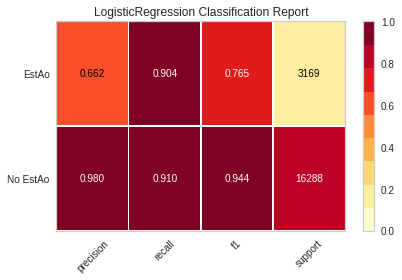

In [12]:
visualizer = ClassificationReport(clf, classes=['No EstAo', 'EstAo'], support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


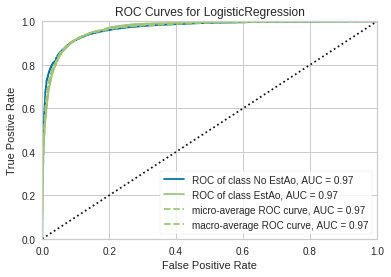

In [13]:
visualizer = ROCAUC(clf, classes=["No EstAo", "EstAo"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


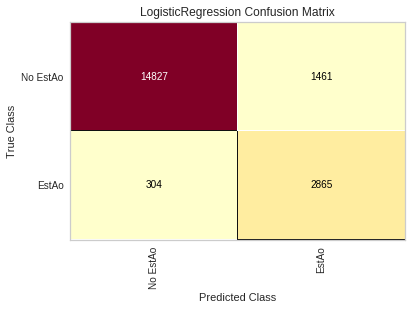

In [14]:
visualizer = ConfusionMatrix(clf, classes=['No EstAo', 'EstAo'], support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

### Example: Insf Ao

In [8]:
%%time

df_test = df_test.loc[df_test['insf_Ao'].notnull(),]
df_test = df_test.reset_index(drop=True)


w2v_features_test = list(map(lambda sen_group: get_w2v_features(W2Vmodel, sen_group), df_test['tokenized_sentences']))
test_w2v = np.array(list(map(np.array, w2v_features_test)))
W=pd.DataFrame(test_w2v)
test = pd.concat([W, df_test], axis=1)

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


CPU times: user 2.57 s, sys: 20.1 ms, total: 2.59 s
Wall time: 2.58 s


In [9]:
train = train.loc[train['insf_Ao'].notnull(),]
train = train.reset_index(drop=True)

In [10]:
X_train, X_test, y_train, y_test = train.iloc[:,0:200], test.iloc[:,0:200], train['insf_Ao'], test['insf_Ao']

time consuming cell below

In [10]:
# %%time
# clf = SVC(C=50, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0, decision_function_shape='ovr', 
#           degree=3, gamma='scale', kernel='linear', max_iter=-1, probability=True, random_state=None, 
#           shrinking=True, tol=0.001, verbose=False)
# clf = clf.fit(X_train, y_train)

CPU times: user 57min 19s, sys: 316 ms, total: 57min 19s
Wall time: 57min 19s


In [14]:
%%time
clf = LogisticRegression(random_state=0, class_weight = 'balanced', penalty = 'l1', solver = 'saga')
clf = clf.fit(X_train, y_train)

CPU times: user 10.9 s, sys: 3.86 ms, total: 10.9 s
Wall time: 10.9 s


/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [15]:
# y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

print(roc_auc_score(y_test, y_prob[:,1]))

0.8603063693821738


/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


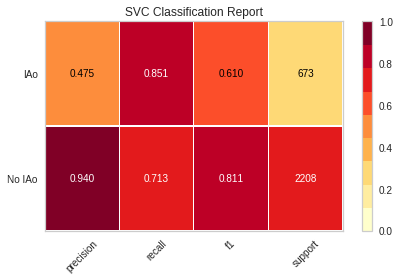

In [13]:
visualizer = ClassificationReport(clf245, classes=['No IAo', 'IAo'], support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


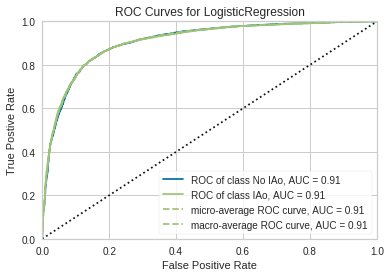

In [21]:
visualizer = ROCAUC(clf, classes=["No IAo", "IAo"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.poof();

/home/ubuntu/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


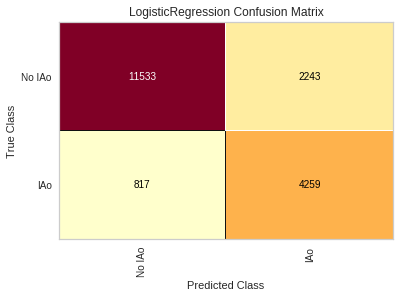

In [22]:
visualizer = ConfusionMatrix(clf, classes=['No IAo', 'IAo'], support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();